In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yfinance as yf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# pick a ticker symbol to run through the training
ticker = 'TSLA'

In [133]:
# articles = pd.read_csv(f'./data/{ticker}_art_df.csv',index_col='date')
dbfile = open('./pickle_jar/articlePickle', 'rb')      
articles = pickle.load(dbfile) 
dbfile.close() 

In [21]:
stocks = pd.read_csv(f'./data/{ticker}_history.csv', index_col='Date')

In [66]:
def get_stock(ticker):
    stock = yf.Ticker(ticker).history(period='1yr')
    stock.columns = [i.lower() for i in stock.columns]
    stock = stock.pct_change()
    stock[['dividends','stock splits']] = stock[['dividends','stock splits']].fillna(0)
    stock.dropna(inplace=True)

    return stock

In [195]:
stocks = get_stock('TSLA')

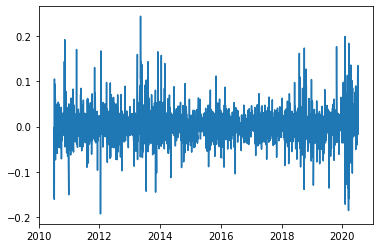

In [207]:
plt.plot(stock['close'],);

In [28]:
# create target columns with prices going up as 1 and down as 0
stocks['target'] = (stocks['close'] >= 0).astype(int)


In [147]:
articles.drop(['name','article','comments','href', 'article_vect','name_vect'], axis=1, inplace=True)

KeyError: "['name' 'article' 'comments' 'href'] not found in axis"

In [149]:
df = pd.merge(stocks, articles, left_index=True, right_index=True, how='outer')


In [138]:
df['2020']

,open,high,low,close,volume,dividends,stock splits,target,article_vect,name_vect,art_clusters,name_clusters
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.008461366, 0.05105899, 0.07668589, -0.00334...","[0.054052733, 0.06796875, 0.11328125, -0.14697...",1.0,0.0
2020-01-02,0.048148,0.022336,0.048821,0.028518,-0.073267,0.0,0.0,1.0,"[0.016928406, 0.045346987, 0.036655273, 0.0230...","[0.039111327, 0.005859375, 0.07011719, 0.08488...",0.0,1.0
2020-01-02,0.048148,0.022336,0.048821,0.028518,-0.073267,0.0,0.0,1.0,"[0.025714949, 0.035415903, 0.020181393, 0.1182...","[0.074672155, -0.050136022, 0.023882184, 0.215...",1.0,0.0
2020-01-03,0.037691,0.054098,0.036067,0.029633,0.865119,0.0,0.0,1.0,"[0.023578098, 0.048830442, 0.018772528, 0.0652...","[-0.0076226126, 0.10231527, 0.037326388, 0.106...",1.0,0.0
2020-01-03,0.037691,0.054098,0.036067,0.029633,0.865119,0.0,0.0,1.0,"[0.043289736, 0.044603832, 0.0043062875, 0.060...","[0.104162596, 0.062109374, -0.08823242, 0.0466...",0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-07,0.100510,0.037531,0.055820,0.013328,0.042295,0.0,0.0,1.0,NaN,NaN,NaN,NaN
2020-07-08,0.000000,-0.008562,0.040615,0.003338,-0.925277,0.0,0.0,1.0,NaN,NaN,NaN,NaN
2020-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.024432188, 0.042598385, 0.010058287, 0.0648...","[0.026672363, 0.01841518, -0.0068751746, 0.132...",1.0,0.0
2020-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.008264161, 0.034227833, 0.011855691, 0.008...","[0.02183024, 0.07195367, -0.011474609, -0.0324...",1.0,0.0


In [150]:
df.ffill(inplace=True)


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2694 entries, 2010-06-30 to 2020-07-11
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           2694 non-null   float64
 1   high           2694 non-null   float64
 2   low            2694 non-null   float64
 3   close          2694 non-null   float64
 4   volume         2694 non-null   float64
 5   dividends      2694 non-null   float64
 6   stock splits   2694 non-null   float64
 7   target         2694 non-null   float64
 8   art_clusters   312 non-null    float64
 9   name_clusters  312 non-null    float64
dtypes: float64(10)
memory usage: 231.5 KB


In [152]:
# the older dates have no article information so now we fill those with 0
# we should fill those with the number 2 for 'no_news' 
df.fillna(2, inplace=True)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2694 entries, 2010-06-30 to 2020-07-11
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           2694 non-null   float64
 1   high           2694 non-null   float64
 2   low            2694 non-null   float64
 3   close          2694 non-null   float64
 4   volume         2694 non-null   float64
 5   dividends      2694 non-null   float64
 6   stock splits   2694 non-null   float64
 7   target         2694 non-null   float64
 8   art_clusters   2694 non-null   float64
 9   name_clusters  2694 non-null   float64
dtypes: float64(10)
memory usage: 231.5 KB


## Modeling


RNN

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
X = df['2020'].drop(columns='target')
y = df['2020']['target']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [210]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Pickle the Scaler
with open('./pickle_jar/model_scaler', 'wb') as fp:
    pickle.dump(ss, fp)

Time Generator

In [157]:
# Create training sequences
train_seq = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
train_seq[0][0].shape

(64, 3, 9)

In [158]:
test_seq = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)
test_seq[0][0].shape

(64, 3, 9)

In [159]:
# Design RNN
model = Sequential()
model.add(GRU(8, input_shape=(3,9), return_sequences=True)) 
model.add(GRU(8, return_sequences=True)) 
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='bce', metrics=['acc'])

In [160]:
hist = model.fit(train_seq, epochs=20, validation_data=test_seq)

Epoch 1/20
4/4 [==============================] - 1s 229ms/step - loss: 0.6846 - acc: 0.6009 - val_loss: 0.6841 - val_acc: 0.5634
Epoch 2/20
4/4 [==============================] - 0s 22ms/step - loss: 0.6820 - acc: 0.6116 - val_loss: 0.6819 - val_acc: 0.5728
Epoch 3/20
4/4 [==============================] - 0s 22ms/step - loss: 0.6796 - acc: 0.6208 - val_loss: 0.6796 - val_acc: 0.5915
Epoch 4/20
4/4 [==============================] - 0s 21ms/step - loss: 0.6773 - acc: 0.6131 - val_loss: 0.6772 - val_acc: 0.5775
Epoch 5/20
4/4 [==============================] - 0s 18ms/step - loss: 0.6743 - acc: 0.6223 - val_loss: 0.6753 - val_acc: 0.5915
Epoch 6/20
4/4 [==============================] - 0s 51ms/step - loss: 0.6723 - acc: 0.6422 - val_loss: 0.6733 - val_acc: 0.5822
Epoch 7/20
4/4 [==============================] - 0s 36ms/step - loss: 0.6698 - acc: 0.6498 - val_loss: 0.6713 - val_acc: 0.5869
Epoch 8/20
4/4 [==============================] - 0s 44ms/step - loss: 0.6674 - acc: 0.6560 - va

In [161]:
# Save the model to a HDF5 file
model.save('./pickle_jar/model_1.h5')